# TEBD and many-body localization

## Part I: Preparations

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm        # Calculating the exponential of a matrix
from scipy.linalg import svd         # Calculating the singular-value-decomposition of a matrix

Write a function returning a canonized MPS for the Neel state. You can use your functions from week 5 to check your implementation. Graphically, the MPS can be represented as (in the Vidal notation):

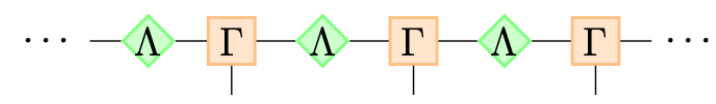

In [3]:
def init_afm_MPS(L):
    """
    Return a Neel state as an MPS.
    """

    Gammas = []
    for i in range(L):
        if ((i+1)%2==0):

            # Even lattice sites are spin up
            Gamma = np.zeros([2, 1, 1])
            Gamma[1, 0, 0] = 1
            Gammas.append(Gamma)
        elif ((i+1)%2==1):

            # Odd lattice sites are spin down
            Gamma = np.zeros([2, 1, 1])
            Gamma[0, 0, 0] = 1
            Gammas.append(Gamma)

    # we add dummy Lambda matrices for bond 0 and L
    Lambdas = [np.ones(1) for _ in range(L+1)]
    return Gammas, Lambdas

Write a function calculating the expectation value of a local operator at each site.

In [4]:
def get_M(Gammas, Lambdas, i):
    """
    Calculate effective single-site wave function on sites i in mixed canonical form.
    The returned array has legs 'i, vL, vR' (as one of the Gammas).
    """
    M = np.tensordot(np.diag(Lambdas[i]), Gammas[i], axes=(1, 1)).transpose((1, 0, 2))
    M = np.tensordot(M, np.diag(Lambdas[i+1]), axes=(2,0))
    return M

Then you can apply the local operator O at this site:

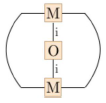

and multiply it with the conjugated M tensor to contract it to a number. Repeating this for every of the L lattice sites results in an array of the local expectation values of operator O.

In [5]:
def site_expectation_value(Gammas, Lambdas, op):
    """
    Calculate expectation values of a local operator at each site.
    """
    result = []
    for i in range(L):
        M = get_M(Gammas, Lambdas, i)
        op_theta = np.tensordot(op, M, axes=(0, 0))
        result.append(np.tensordot(M.conj(), op_theta, axes=([0, 1, 2], [0, 1, 2])))
    return np.real_if_close(result)

For our purposes it is also interesting to look at the entanglement entropy of certain cuts at site j of the full chain. You already implemented this function in last week's exercise:
$$S_{ent}(j) = -\sum_i \Lambda_i^2 \log \Lambda_i^2$$
where $$\Lambda$$ are the Schmidt values at site j

In [6]:
def entanglement_entropy(Lambdas, L):

    """
    Return the (von-Neumann) entanglement entropy for a bipartition at any of the bonds.
    """

    result = []
    for i in range(1, L):
        S = Lambdas[i].copy()
        S[S < 1.e-20] = 0.  # 0*log(0) should give 0; avoid warning or NaN.
        S2 = S * S
        assert abs(np.linalg.norm(S) - 1.) < 1.e-14
        result.append(-np.sum(S2 * np.log(S2)))
    return np.array(result)

# Part II: TEBD Algortihm

Start with a function implementing the two site Hamiltonian of the Heisenberg model

In [7]:
def H_heisenberg(h, L, delta=1):
    """
    Calculate a two-site, bond Hamiltonian of the Heisenberg model
    h is an array of the random external field for each lattice site
    L is the length of the chain
    delta is the anisotropy (delta=1 -> Heisenberg, delta=0 -> XY, 0<delta<1 -> XXZ)
    """

    # Pauli matrices
    sx = np.array([[0., 1.], [1., 0.]])
    sy = np.array([[0., -1j], [1j, 0.]])
    sz = np.array([[1., 0.], [0., -1.]])
    Id = np.eye(2)

    H_list = []
    for i in range(L - 1):
        gL = gR = 0.5
        if i == 0: # first bond
            gL = 1
        if i + 1 == L - 1: # last bond
            gR = 1
        H_bond = np.kron(sx, sx) + np.kron(sy, sy)+ delta * np.kron(sz, sz) + gL * h[i] * np.kron(sz, Id) + gR * h[i+1] * np.kron(Id, sz)
        # H_bond has legs ``i, j, i*, j*``
        H_list.append(np.reshape(H_bond, [2, 2, 2, 2]))

    return H_list

Write a function calculating the time evolution operator U acting on a bond i

In [8]:
def calc_U_bonds(H_bonds, dt):
    """
    Given a Hamiltonian, calculate U_bonds[i] = expm(-dt*H_bonds[i])
    Real dt corresponds to imaginary time evolution
    """

    d = H_bonds[0].shape[0]
    U_bonds = []
    for H in H_bonds:
        H = np.reshape(H, [d * d, d * d]) # reshape into matrix form
        U = expm(-dt * H)
        U_bonds.append(np.reshape(U, [d, d, d, d]))
    return U_bonds

To ensure that our compression of the MPS remains after each evolution step, we have to implement a function to split and truncate the two-site wavefunction.

In [9]:
def split_truncate_theta(theta, chi_max=10, eps=1e-8):
    """
    Split and truncate a two-site wave function in mixed canonical form.
    Split a two-site wave function as follows::
          vL --(theta)-- vR     =>    vL --(X)--diag(Y)--(Z)-- vR
                |   |                       |             |
                i   j                       i             j
    Afterwards, truncate in the new leg (labeled 'vC').
    Parameters
    ----------
    theta : np.Array[ndim=4]
        Two-site wave function in mixed canonical form, with legs 'i, j, vL, vR'.
    chi_max : int
        Maximum number of singular values to keep
    eps : float
        Discard any singular values smaller than that.
    Returns
    -------
    X : np.Array[ndim=3]
        Left-canonical matrix on site i, with legs 'i, vL, vC'
    Y : np.Array[ndim=1]
        Singular/Schmidt values.
    Z : np.Array[ndim=3]
        Right-canonical matrix on site j, with legs 'j, vC, vR'
    """

    dL, dR, chivL, chivR = theta.shape
    theta = theta.transpose((2, 0, 1, 3))
    theta = np.reshape(theta, [chivL * dL, dR * chivR])
    X, Y, Z = svd(theta, full_matrices=False)

    # truncate
    chivC = min(chi_max, np.sum(Y > eps))
    assert chivC >= 1

    piv = np.argsort(Y)[::-1][:chivC]  # keep the largest 'chivC' singular values
    Err = np.sum(Y[chivC:])            # Sum truncated singular values to estimate error of truncation
    X, Y, Z = X[:, piv], Y[piv], Z[piv, :]
    # renormalize
    Y = Y / np.linalg.norm(Y)          # == Y/sqrt(sum(Y**2))
    # split legs of X and Z
    X = np.reshape(X, [chivL, dL, chivC]).transpose((1, 0, 2))
    Z = np.reshape(Z, [chivC, dR, chivR]).transpose((1, 0, 2))

    return X, Y, Z, Err

Write a function to update each MPS bond according to the following scheme:

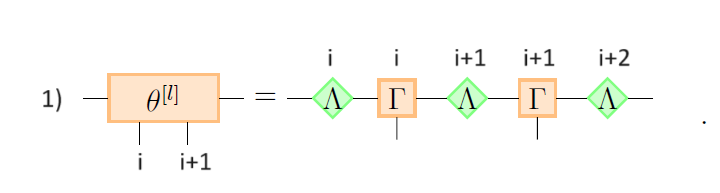

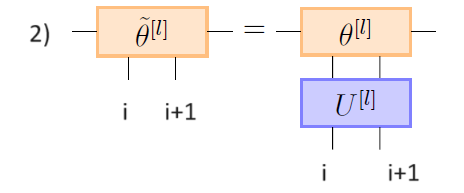

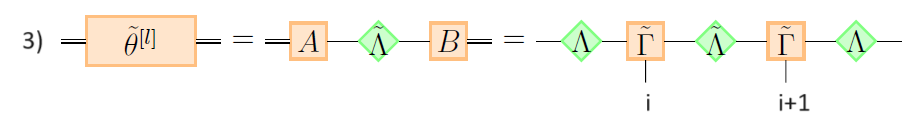

In [10]:
def update_bond(Gammas, Lambdas, i, U_bond, chi_max, eps=1e-8):
    """
    """
    # (vL, vL) * (i, vL, vR) -> (vL, i, vR)
    theta=np.tensordot(np.diag(Lambdas[i]), Gammas[i],axes=(1,1))
    # (vL, i, vR) * (vR, vR) -> (vL, i, vR)
    theta=np.tensordot(theta,np.diag(Lambdas[i+1]),axes=(2,0))
    # (vL, i, vR) * (j, vR, vR+1) -> (vL, i, j, vR+1)
    theta=np.tensordot(theta,Gammas[i+1],axes=(2,1))
    # (vL, i, j, vR+1) * (vR+1, vR+1) -> (vL, i, j, vR+1)
    theta=np.tensordot(theta,np.diag(Lambdas[i+2]),axes=(3,0))

    # apply U
    # (vL, i, j, vR+1) * (i, j, i*, j*) -> (vL, vR+1, i*, j*)
    theta = np.tensordot(theta,U_bond,axes=([1,2],[0,1]))

    # (vL, vR+1, i*, j*) -> (i*, j*, vL, vR+1)
    theta = np.transpose(theta, (2,3,0,1))

    # split and truncate
    X, Lambda, Z, Err = split_truncate_theta(theta, chi_max, eps)

    # put back into MPS
    # (vL, vL) * (i, vL, vR) -> (vL, i, vR) -> (i, vL, vR)
    Gammas[i] = np.tensordot(np.diag(Lambdas[i]**(-1)),X, axes=(1,1)).transpose((1, 0, 2))
    Lambdas[i+1] = Lambda
    # (i+1, vL, vR) * (vR, vR) -> (i+1, vL, vR)
    Gammas[i+1] = np.tensordot(Z,np.diag(Lambdas[i+2]**(-1)),axes=(2,0))

    return Gammas, Lambdas, Err

Finally, implement the TEBD algorithm

In [11]:
def run_TEBD(L, Gammas, Lambdas, U_bonds, chi_max, eps=1e-8):

    """
    Evolve the state psi given by 'Lambdas' and 'Gammas' for 'N_steps' time steps with (first order) TEBD.
    Return evolved state as 'Gammas' and 'Lambdas' as well as the truncation Error
    """
    Error = 0
    Nbonds = L - 1
    assert len(U_bonds) == Nbonds                 # Check if U has the correct number of bonds

    for k in [0, 1]:                              # even, odd
        for i_bond in range(k, Nbonds, 2):        # Apply U_even and U_odd separately & update psi
            Gammas, Lambdas, Err = update_bond(Gammas, Lambdas, i_bond, U_bonds[i_bond], chi_max, eps)
            Error += Err
    return Gammas, Lambdas, Error

Check your Neel state MPS by calculating the expectation value of Sz

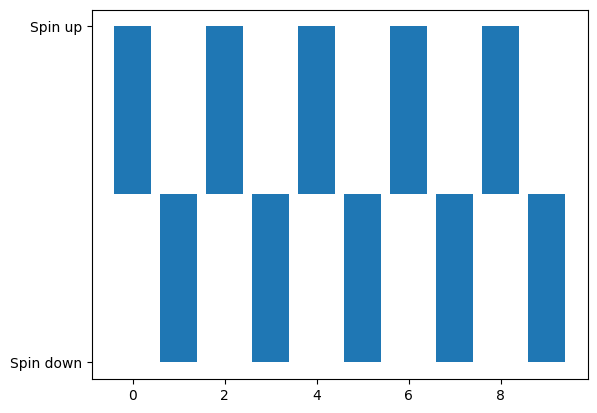

In [12]:
L = 10                                          # Length of chain
Sz = np.array([[1., 0.], [0., -1.]])            # Operator to use for expectation
Gammas, Lambdas = init_afm_MPS(L)               # Initial wavefunction
M = site_expectation_value(Gammas, Lambdas, Sz) # <psi|S_z|psi>

# Plot spin orientation per site
plt.bar(np.arange(0,L), M)
plt.yticks([1,-1],["Spin up", "Spin down"])
plt.show()

# Part III

## Check convergence & truncation error for several disorder strengths

In [13]:
# Define chain length and generate a random field
L = 14
h_rand = np.random.rand(L)

In [ ]:
# Parameters
dt = 0.01
chi = 50
N_steps = 1000
Sz = np.array([[1., 0.], [0., -1.]])

ts = np.arange(0., 100., dt)
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(10, 7))

for w in range(0,12, 2):
    h = -w + (h_rand * (2*w))            # Scale random field to desired range [-w,w]
    H = H_heisenberg(h, L)               # Get the corresponding two-site Hamiltonian
    U_bonds = calc_U_bonds(H, 1.j*dt)    # Get the list of bond operators U
    Gammas, Lambdas = init_afm_MPS(L)    # Get the initial afm starting state


    er = 0
    for t in range(N_steps):             # During N_steps timesteps, evolve initial state
        Gammas, Lambdas, Error = run_TEBD(L, Gammas, Lambdas, U_bonds, chi)
        er += Error                      # Get summed truncation error for each disorder realization
    ax1.scatter(w, er)

ax1.set_ylabel("Truncation Error")
ax1.set_xlabel("Potential")
plt.show()

In [ ]:
# Parameters
dt = 0.01
N_steps = 1000
Sz = np.array([[1., 0.], [0., -1.]])

ts = np.arange(0., 100., dt)
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(10, 7))

# Change chi with increasing disorder, localized chains with limited entanglement need smaller chi
wvals = np.arange(0, 10, 2)
chivals = np.array([100000, 50000, 10000, 1000, 500])
for w, chi in zip(wvals, chivals):

    h = -w + (h_rand * (2*w))            # Scale random field to desired range [-w,w]
    H = H_heisenberg(h, L)               # Get the corresponding two-site Hamiltonian
    U_bonds = calc_U_bonds(H, 1.j*dt)    # Get the list of bond operators U
    Gammas, Lambdas = init_afm_MPS(L)    # Get the initial afm starting state

    er = 0
    for t in range(N_steps):             # During N_steps timesteps, evolve initial state
        Gammas, Lambdas, Error = run_TEBD(L, Gammas, Lambdas, U_bonds, chi)
        er += Error                      # Get summed truncation error for each disorder realization

    ax1.scatter(w, er)

ax1.set_ylabel("Truncation Error")
ax1.set_xlabel("Potential")
plt.show()

## Use your implementation to probe the many body localization

The Heisenberg model in a random field can be used to study the transition between an ergodic and a localized phase. Starting from the antiferromagnetic state of Part I, a clean system is expected to evolve to zero antiferromagnetic order in thermal equilibrium. However, if the system is localized due to the presence of disorder, a finite antiferromagnetic order will remain.

Additionally, an interesting property to study is the growth of the half-chain entropy. This quantity describes the entanglement between the two halves of the chain and changes significantly when entering the localized phase. The initial quick rise of the entanglement corresponds to expansion of wave packets to a size of the order of the localization length. This rise is independent of the disorder strength. After this initial expansion, the entanglement saturates in the disorder-free case but increases logarithmically for any nonzero disorder.

In [ ]:
# Parameters
dt = 0.01
chi = 100
N_steps = 10000
Sz = np.array([[1., 0.], [0., -1.]])

ts = np.arange(0., dt*N_steps, dt)

ws = range(0, 12, 2)
M_afms = np.zeros((len(ws), N_steps))
ent_entropies = np.zeros((len(ws), N_steps))

for i, w in enumerate(ws):
    h = -w + (h_rand * (2*w))            # Scale random field to desired range [-w,w]
    H = H_heisenberg(h, L)               # Get the corresponding two-site Hamiltonian
    U_bonds = calc_U_bonds(H, 1.j*dt)    # Get the list of bond operators U
    Gammas, Lambdas = init_afm_MPS(L)    # Get the initial afm starting state

    for t in range(N_steps):
        # Calculate antiferromagnetic order per evolution step
        M_afms[i, t] = np.abs(np.sum(site_expectation_value(Gammas, Lambdas, Sz)*np.tile([-1, 1], L//2)))/L
        # Calculate half-chain entropy per evolution step
        ent_entropies[i, t] = entanglement_entropy(Lambdas, L)[L//2]
        # Evolve wavefunction in time
        Gammas, Lambdas, Error = run_TEBD(L, Gammas, Lambdas, U_bonds, chi)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 7))

for i, w in enumerate(ws):
    ax1.semilogx(ts, M_afms[i, :], label=f"w={w}")
    ax2.semilogx(ts, ent_entropies[i, :], label=f"w={w}")

ax2.legend()
ax1.set_ylabel("$S_{afm}$")
ax2.set_ylabel("half-chain entropy")
ax2.set_xlabel("time $t$")
plt.show()

To remove unwanted oscillations, one usually averages over several realizations of the disorder field.

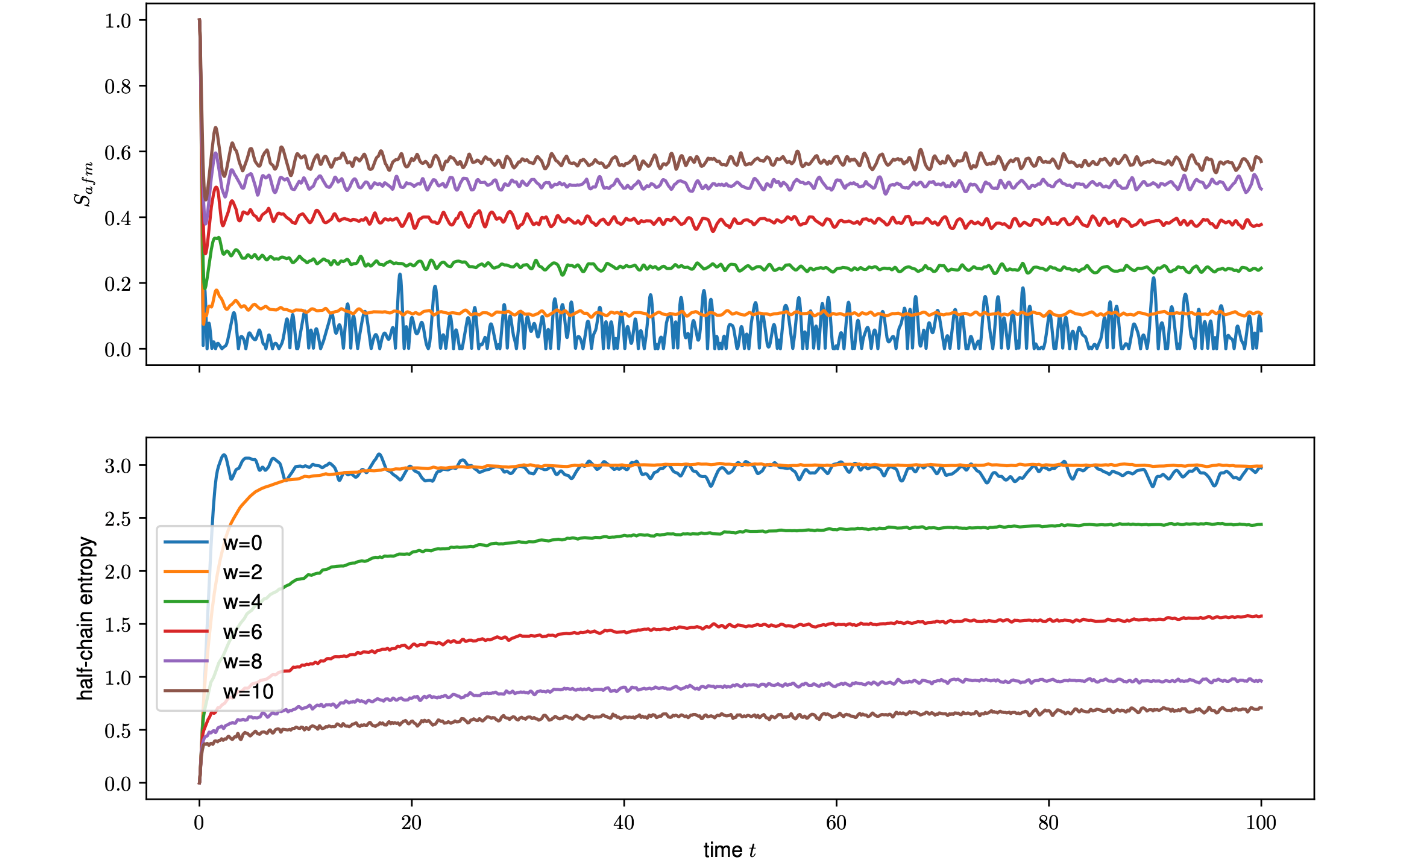

In the last picture you can nicely see the logarithmic increase of entanglement at high $t$, as expected for many-body-localization.

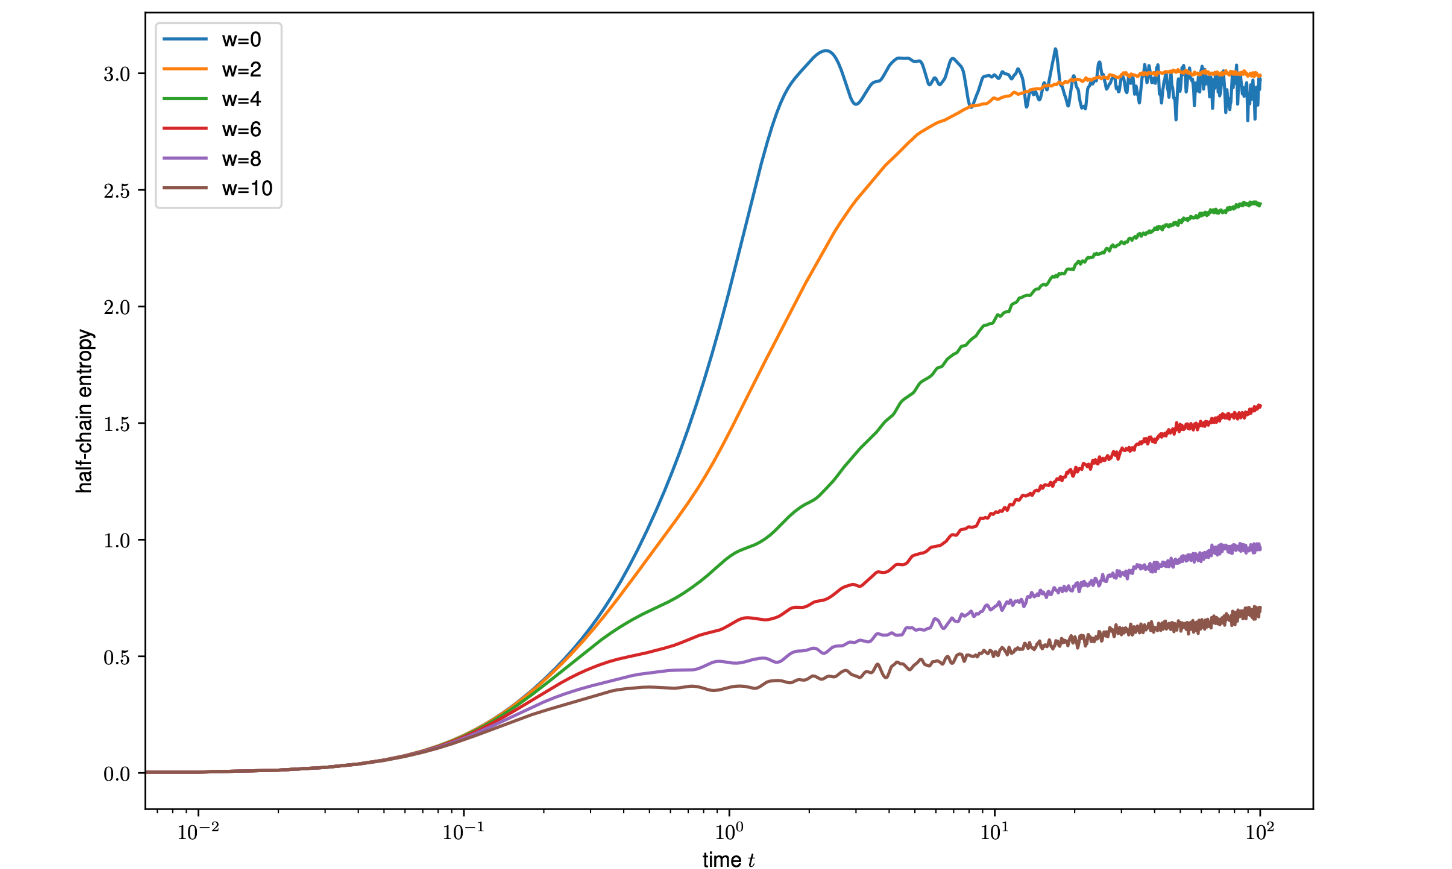